# Distributional assumption -- The distribution includes biases!

Word vectors encode the linguistic contexts in which words appear. We can therefore ask how much linguistic bias -- which echoes societal biases -- is encoded in word vectors. Because much of web text is written by white, heterosexual North American men, as well as their Western European counterparts, the texts include biases that get encoded via distributional semantics methods.

Societal biases include, but are not exclusive to

* race
* ethnicity
* gender
* sexuality
* disabled status
* age
* intersections of all of these

We know that neural language models produce text that amplifies these biases. For example, recent studies suggest that neural language models and chat systems like ChatGPT have a predominantly "cool (white, affluent) mom" orientation toward social problems. The models in production today have lots of bumpers to prevent producing racist, sexist, etc. text.

For this, I will show you a cool projection method called "subspace" analysis, which produces a vector between two end-points.

One of the first places studying gender bias in word vectors was done was in [Bolukbası et al. (2016)](https://proceedings.neurips.cc/paper_files/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) who used a combination of:

* Static word vectors from `word2vec`
* Difference vectors between two "endpoints" of a binary spectrum (masculine <--> feminine)
* Principal components analysis over that endpoint
* The above steps produce a "gender subspace" vector
* Compute similarity between each vector for an occupation -- which can be biased toward different genders to different degrees, and verified with census data -- and the gender subspace vector

For our experiment, we will load in some vectors from `spaCy` and quantify the degree to which gender bias exists for some specific words:

```python
pairs = [
  ('he', 'she'),
  ('his', 'hers'),
  ('him', 'her'),
  ('his', 'her'),
  ('John', 'Mary'),
  ('himself', 'herself'),
  ('father', 'mother'),
  ('guy', 'gal'),
  ('boy', 'girl'),
  ('male', 'female')
]
```

### Food for thought
* Can you think of other pairs of words that might be useful here? (brother, sister), (wife, husband), (doctor, nurse) ?
* What about other dimensions from one end to another might be able to use this method? age - young <--> old, first name last name
* How can these "endpoints" be used for answering questions other than bias? maybe it can look into 

In [8]:
# imports
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

import spacy
! python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

from sklearn.decomposition import TruncatedSVD # to project down into smaller dimension
from scipy.spatial.distance import cosine

from plotnine import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 754.6 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## Get occupations

There are lots of ways to get career or occupational bias. Here, we download a dataset that has lots of different biases -- gender, race, ethnicity -- and was used to study bias in GPT-2. We can check that the Bolukbası method correlates with:

- The gender bias in US Census data
- The gender bias that GPT-2 produces

https://github.com/oxai/intersectional_gpt2

Data:
https://github.com/oxai/intersectional_gpt2/blob/master/data/GPT-2/US_data/us_rows_data.csv

In [9]:
# upload the file
df = pd.read_csv("gpt_vs_us_data.csv")
df.head()

# us_white_F is average bias in the census for white women
# gpt_white_F is the average bias produced by GPT-2
# ask dr jacobs what this means ~~~~~~~~~

,job,gpt_asian_F,gpt_asian_M,gpt_black_F,gpt_black_M,gpt_hispanic_F,gpt_hispanic_M,gpt_white_F,gpt_white_M,gpt_base_F,...,diff_asian_F,diff_asian_M,diff_black_F,diff_black_M,diff_hispanic_F,diff_hispanic_M,diff_white_F,diff_white_M,diff_base_F,diff_base_M
0,babysitter,0.00,0.00,12.49,0.00,25.81,0.00,96.41,0.00,94.00,...,-3.08,-0.22,-3.76,-1.15,2.83,-1.62,25.43,-5.02,0.60,-6.60
1,secretary / assistant,4.03,1.52,8.09,2.09,7.94,4.48,68.66,47.77,66.27,...,0.77,1.28,-0.01,1.49,-4.55,3.57,-10.75,41.98,-26.93,24.47
2,receptionist,4.15,1.65,6.01,2.09,17.87,8.95,46.74,13.18,70.50,...,0.05,1.16,-7.74,0.44,-1.60,6.62,-20.95,5.07,-18.80,15.80
3,cleaner / housekeeper / maid,5.38,3.50,8.65,3.81,9.93,5.75,35.93,15.48,76.14,...,1.73,3.05,-6.84,1.89,-33.86,0.33,-28.32,7.54,-12.86,9.14
4,nurse,4.15,0.55,9.71,2.09,16.54,2.98,67.19,9.88,83.66,...,-4.02,-0.47,-1.31,0.71,10.14,2.19,-0.28,1.46,-5.24,0.56


In [10]:
# extract all the names of all the professions
jobs = []
for i, row in df.iterrows():
  job = row['job']
  jobs_ = job.split("/")
  for job_ in jobs_:
    jobs.append(job_.strip())

## Define the words used for the "endpoints" of the projection

The idea here is that if we compute the "difference" (subtraction) between "masculine" vectors and "feminine" vectors, we can compute the subspace that corresponds to the axes that are correlated with some linguistic dimension of bias.

In [11]:
pairs = [
  ('he', 'she'),
  ('his', 'hers'),
  ('him', 'her'),
  ('his', 'her'),
  ('John', 'Mary'),
  ('himself', 'herself'),
  ('father', 'mother'),
  ('guy', 'gal'),
  ('boy', 'girl'),
  ('male', 'female'),
  ('masculine', 'feminine'),
]

In [12]:
difference_vectors =  [normalize(nlp(m).vector.reshape(1, -1) - nlp(f).vector.reshape(1, -1))[0] for m, f in pairs]
#WHAT DOES NORMALIZE DO??? AND THE RESHAPE ARGUMENTS

# Learn the subspace using PCA

PCA learns the dominant dimensions that characterize a space. If we project to a single dimension, this will result in one "component" that characterizes the differences between "masculine" vectors and "feminine" vectors.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1920px-GaussianScatterPCA.svg.png" width=400>

PCA demonstration, Wikipeda

In [13]:
pca = TruncatedSVD(n_components=1) # one gender dimension
pca.fit(difference_vectors)

TruncatedSVD(n_components=1)

As an annoying implementational detail, Bolukbası normalize word vectors to the unit circle -- but this might not be necessary.

In [14]:
job_vectors = [normalize(nlp(job).vector.reshape(1, -1))[0] for job in jobs]

# Compute the bias scores using cosine similarity

We can look at how much the learned axis above "weighs" in the same direction as any particular job word vector. Above, we extract the vectors for a bunch of job titles, and we'll compute the cosine similarity (angle difference) between the "gender subspace" vector and the job title vector.

The numbers weigh on the differences -- we subtracted feminine from masculine, so higher values indicate more feminine "loadings" and lower values are more "masculine."

In [15]:
scores = []
for i, job in enumerate(job_vectors):
  job_title = jobs[i]
  scores.append((job_title, cosine(job, normalize(pca.components_).reshape(-1))))

In [16]:
scores_df = pd.DataFrame(scores, columns=['job', 'bias'])

### Correlation of spaCy vectors to GPT-2

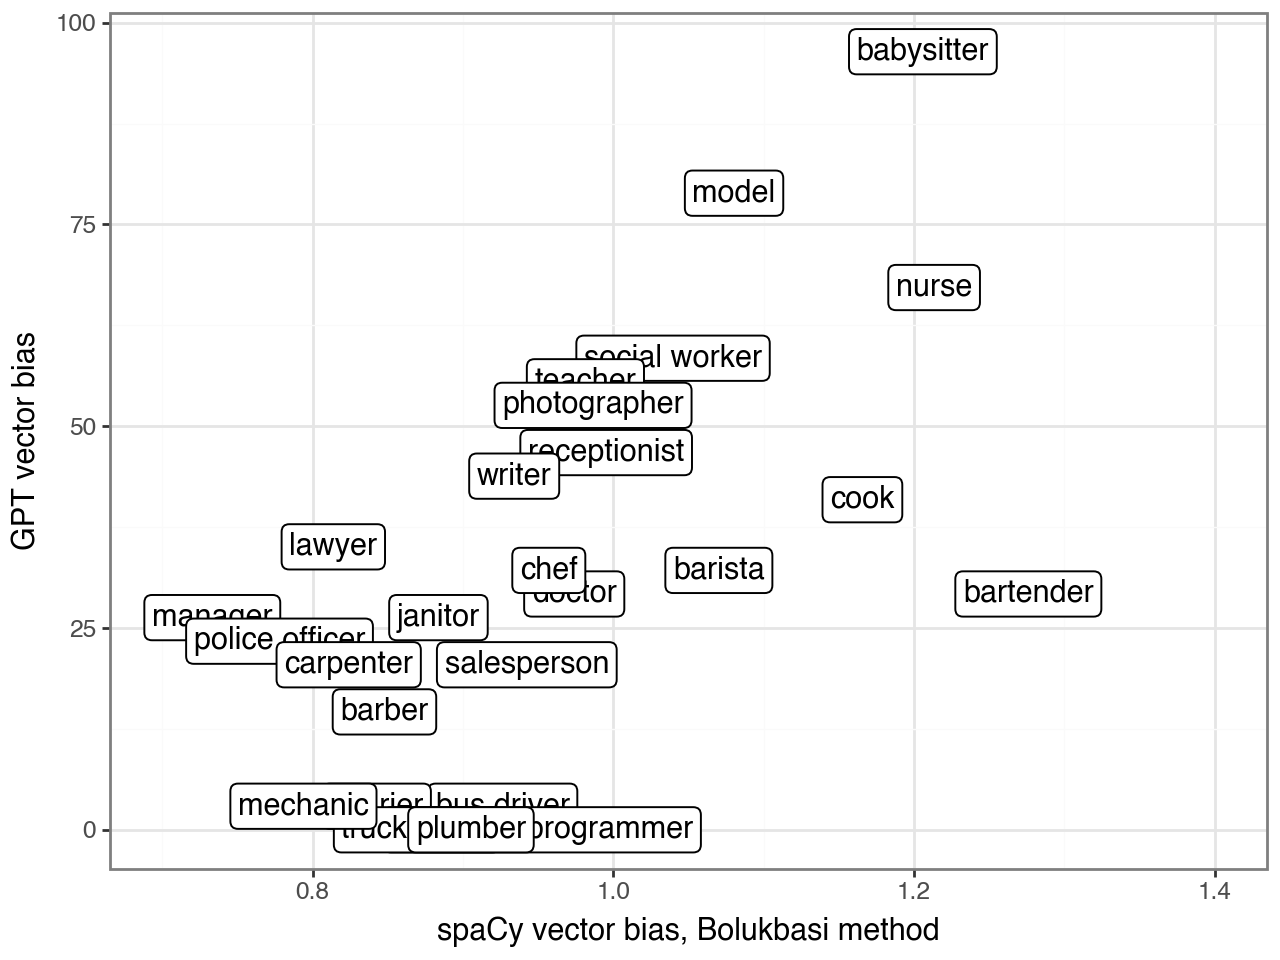

In [17]:
(ggplot(scores_df.merge(df),
       aes(x='bias', y='gpt_white_F', label='job')) + geom_label() + theme_bw()
       + xlab("spaCy vector bias, Bolukbasi method")
       + ylab("GPT vector bias")
       + xlim(0.7, 1.4))

### Correlation of spaCy vectors to US Census data

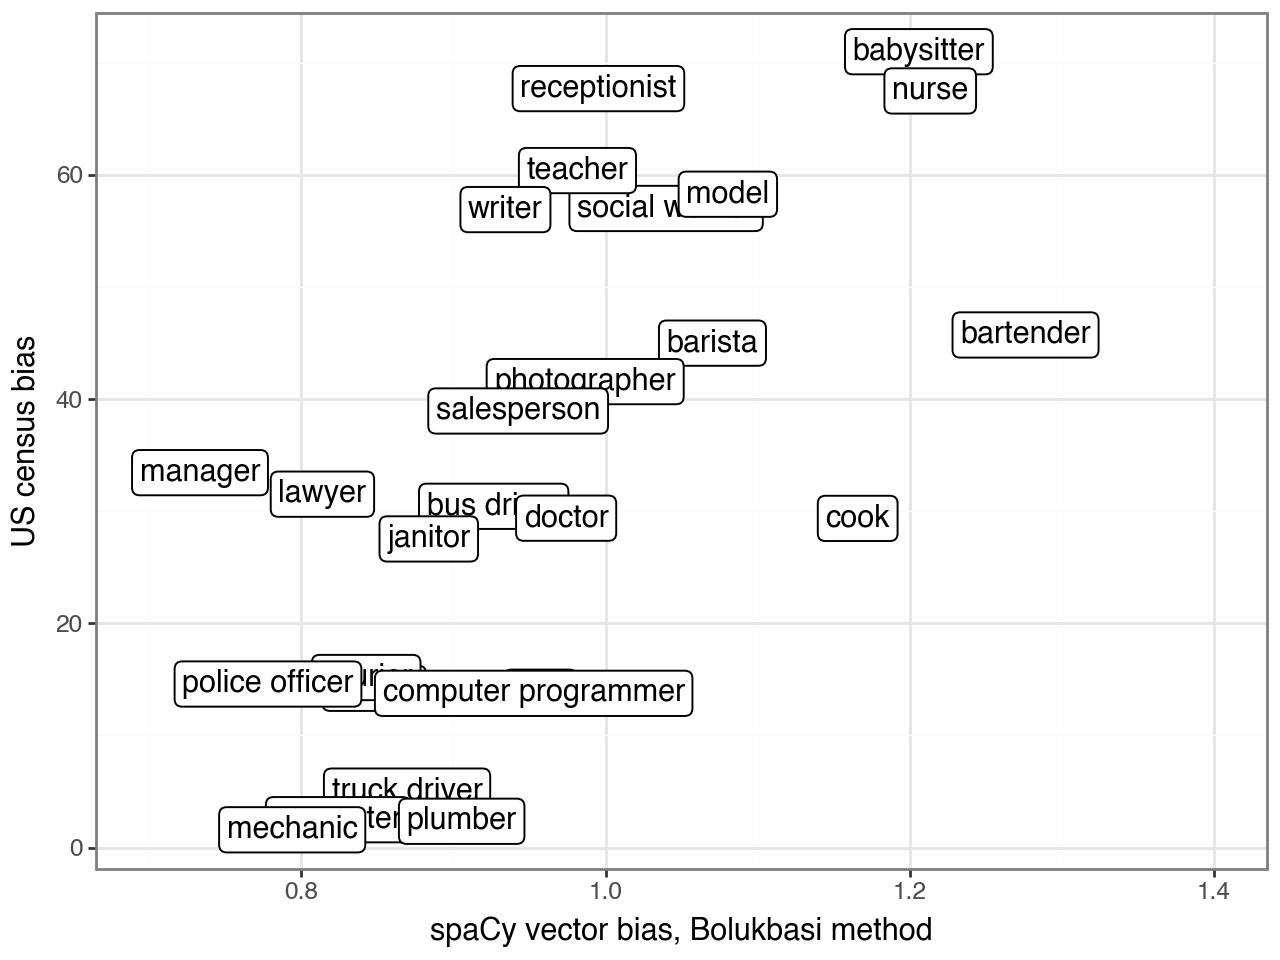

In [18]:
(ggplot(scores_df.merge(df),
       aes(x='bias', y='us_white_F', label='job')) + geom_label() + theme_bw()
       + xlab("spaCy vector bias, Bolukbasi method")
       + ylab("US census bias")
       + xlim(0.7, 1.4))